In [16]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path
import pandas as pd
from latex_formater import get_final_answer

save_path = Path('~/GitHub/gold-ai-olympiad/data/MATH/Predictions/').expanduser()

# load the results and combine them back into a single dataframe
results = pd.concat([
    pd.read_json(save_path / f)
    for f in save_path.iterdir()
    if f.suffix == '.json'
])

In [3]:
print(f'Loaded {len(results)} results')

results.iloc[0]

Loaded 145000 results


dataset                                   Intermediate_Algebra_train
i                                                                  0
problem            Shown below are rows 1, 2, and 3 of Pascal's t...
level                                                        Level 5
type                                            Intermediate Algebra
solution           More generally, suppose $(a_i),$ $(b_i),$ $(c_...
boxed                                                    \frac{1}{2}
model                                                    Llama-2-13b
method                                                autoregressive
prediction          Sure! Here's the calculation step by step:\n\...
generation_args    {'debug': False, 'seed': None, 'model': 'meta-...
Name: 0, dtype: object

In [17]:
class Metric():
    def __init__(self):
        super().__init__()

    def process(self, results):
        pass

    def __call__(self, results):
        return self.process(results)

In [13]:
class BoxedMatch(Metric):
    def process(self, results):
        results['boxed_pred'] = results['prediction'].apply(get_final_answer)
        results['boxed_true'] = results['boxed']
        results['boxed_match'] = results['boxed_true'] == results['boxed_pred']

        # very slow, probably don't use
        # results['match'] = results.apply(lambda x: is_equiv(x['boxed_true'], x['boxed_pred']), axis=1)

        # set first columns to be ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'match', ...]
        # cols = ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'boxed_match']
        # cols.extend([col for col in results.columns if col not in cols])
        return results  #[cols]

In [8]:
from nltk.tokenize import sent_tokenize

from roscoe.score import (
    SEQ_EMB_MODEL_TYPES,
    Chain,
    Evaluator,
    REASONING_SCORES,
    UNSUPERVISED_SCORES,
    SENT_TRANS,
    SIMSCE
)
from roscoe.utils import (
    print_and_reset_max_gpu_memory,
    save_scores,
    split_gsm8k_gpt3_generations_to_steps,
)


class ReasoningSteps(Chain):
    def __init__(self, line: str, type="regular") -> None:
        self.chain = self.parse_chain(line, type=type)

    def parse_chain(self, chain: str, type: str) -> list[str]:
        """
        Change formatting.

        Returns list of steps in reasoning chain.
        """
        if type == "gsm8k_ref":
            return chain.split("IGNORE THIS. Ground truth here for reference. ")[
                1
            ].split('\n')
        elif type == "gsm8k_hypo":
            return split_gsm8k_gpt3_generations_to_steps(reasoning=chain)
        elif type == "regular":
            return sent_tokenize(chain)
        else:
            raise NotImplementedError(f"{type} chain type is not supported")

ImportError: Scorer needs SimCSE model installed. 
 pip install -U simcse

In [9]:
!pip install -U simcse

  Using cached simcse-0.4.tar.gz (18 kB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.5.4.tar.gz (25.2 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [583 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
        Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
        Using cached setuptools-

In [6]:
# # get memory usage of evaluator.ppl_model
# param_size = 0
# for param in evaluator.grmr_model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in evaluator.grmr_model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()
# 
# size_all_mb = (param_size + buffer_size) / 1024 ** 3
# print('model size: {:.3f}GB'.format(size_all_mb))

In [14]:
from roscoe.score import Evaluator


class ROSCOE(Metric):
    def __init__(self, score_types=REASONING_SCORES, model_type=SIMSCE,
                 transformer_model="facebook/roscoe-512-roberta-base", ppl_model="gpt2-large", discourse_batch=64 * 16,
                 coherence_batch=64 * 16):
        super().__init__()
        self.evaluator = Evaluator(
            score_types=score_types,
            model_type=model_type,
            transformer_model=transformer_model,
            ppl_model=ppl_model,
            discourse_batch=discourse_batch,
            coherence_batch=coherence_batch,
            hypos=[],
            context=[],
        )

    def process(self, results):
        hypos = [
            ReasoningSteps(str(pred))
            for pred in results['prediction']
        ]
        refs = [
            ReasoningSteps(str(solution))
            for solution in results['solution']
        ]
        context = [
            ReasoningSteps(str(problem))
            for problem in results['problem']
        ]

        self.evaluator.set_hypos(hypos)
        self.evaluator.set_references(refs)
        self.evaluator.set_context(context)
        scores = self.evaluator.evaluate()
        return scores
        # results['ROSCOE'] = scores
        # return results

In [8]:
# import torch
# 
# torch.set_float32_matmul_precision('medium')

from comet import download_model, load_from_checkpoint


class COMET(Metric):
    def __init__(self, model_name="Unbabel/XCOMET-XL", batch_size=16, gpus=1):
        super().__init__()
        self.model_name = model_name
        self.model_path = download_model(model_name)
        self.model = load_from_checkpoint(self.model_path)

        self.batch_size = batch_size
        self.gpus = gpus

    def process(self, results):
        data = [
            {
                "src": row['problem'],
                "mt": row['prediction'],
                "ref": row['solution']
            } for _, row in results.iterrows()
        ]
        model_output = self.model.predict(data, batch_size=self.batch_size, gpus=self.gpus)
        results[self.model_name] = model_output
        return results

In [15]:
boxed_match = BoxedMatch()
results = boxed_match(results)

save_path = Path('~/GitHub/gold-ai-olympiad/data/MATH/Predictions/BoxedMatch').expanduser()
save_path.mkdir(parents=True, exist_ok=True)
import pickle
with open(save_path / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

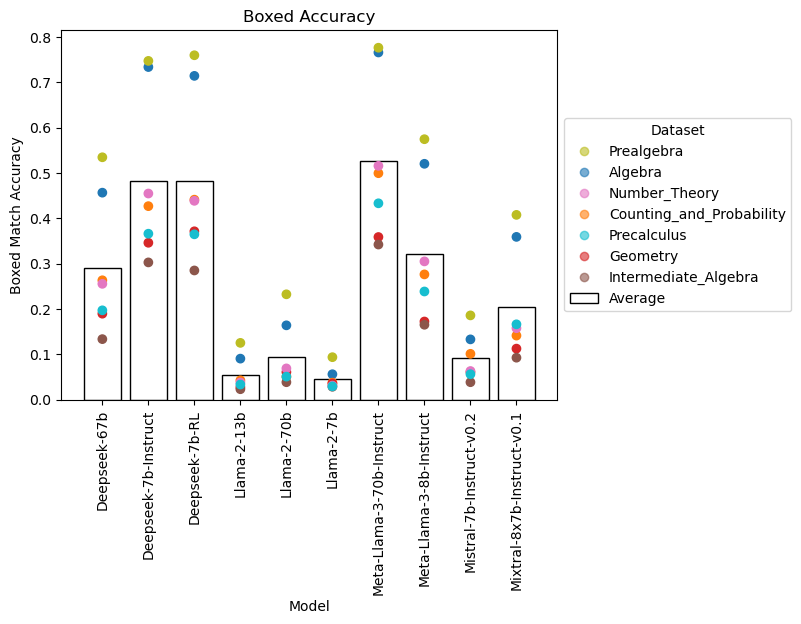

In [10]:
# plot the results
import matplotlib.pyplot as plt

boxed_accuracy = results.groupby(['model', 'dataset'])['boxed_match'].mean()
model_accuracy = boxed_accuracy.groupby('model').mean()
dataset_accuracy = boxed_accuracy.groupby('dataset').mean()

plt.bar(model_accuracy.index, model_accuracy, edgecolor='black', linewidth=1, color='none')

# plot each dataset as a separate point with model on the x axis and boxed_match on the y axis
boxed_accuracy = results.groupby(['model', 'dataset'])['boxed_match'].mean()

colors = pd.Categorical(boxed_accuracy.index.get_level_values('dataset'))
scatter = plt.scatter(boxed_accuracy.index.get_level_values('model'), boxed_accuracy, c=colors.codes, cmap='tab10')
plt.xlabel('Model')
plt.ylabel('Boxed Match Accuracy')
plt.title('Boxed Accuracy')
handles, labels = scatter.legend_elements(prop='colors', alpha=0.6, fmt='{x:.0f}')
labels = [colors.categories[int(label)].replace('_train', '') for label in labels]

# sort the legend by the average accuracy
sorted_idxs = dataset_accuracy.sort_values(ascending=False).index
handles = [handles[colors.categories.get_loc(dataset)] for dataset in sorted_idxs]
labels = [labels[colors.categories.get_loc(dataset)] for dataset in sorted_idxs]

# add bars to the legend
handles.append(plt.Rectangle((0, 0), 1, 1, fc='none', edgecolor='black'))
labels.append('Average')

plt.legend(
    handles, labels,
    title='Dataset',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.xticks(rotation=90)

plt.show()

In [11]:
roscoe = ROSCOE()
results = roscoe(results)

/lfs/skampere1/0/kaif/conda/envs/TheoremSense/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at facebook/roscoe-512-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it fo

KeyboardInterrupt: 

In [ ]:
# because scoring using roscoe takes so long, we will score in batches
# and checkpoint the results
import pickle

roscoe = ROSCOE()

temp_save_path = save_path / 'temp'
temp_save_path.mkdir(parents=True, exist_ok=True)
# group by dataset
for dataset, group in results.groupby('dataset'):
    output = roscoe(group)
    # group.to_json(temp_save_path / f'{dataset}.json')
    with open(temp_save_path / f'{dataset}.pkl', 'wb') as f:
        pickle.dump(output, f)

Some weights of RobertaModel were not initialized from the model checkpoint at facebook/roscoe-512-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Scoring chains ... :  45%|███████████████████████▌                            | 5863/12950 [3:42:22<10:20:55,  5.26s/it]